**Name:** __SHEN Huajun__

**EID:** __huajushen2__

**Student_ID:** __56391566__

# CS5489 - Tutorial 10
## Using Deep Features

In this tutorial you will train a classifier to classify images with different types of cakes using deep features.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
import skimage.io
import skimage.transform

Second, initialize Keras and Tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization, \
                                    GlobalAveragePooling2D, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import logging
logging.basicConfig()
import struct
print(keras.__version__, tf.__version__)
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')

2.4.0 2.4.1


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `cakes.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [3]:
imgdata = []
classes = []

# load the zip file
filename = 'cakes.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "cakes/*/*.jpg"):
        
        # filename is : cakes/class/file.jpg
        (fdir1, fname)  = os.path.split(name)  # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class 

        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        #img = matplotlib.image.imread(myfile)
        img = skimage.io.imread(myfile)
        img2 = skimage.transform.resize(img, (224,224), anti_aliasing=False)
        
        myfile.close()

        imgdata.append(img2)
        classes.append(fclass)
        
zfile.close()
print(len(imgdata))
print(img.size)

C:\Tools\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262144 bytes but only got 0. Skipping tag 0
  warnings.warn(
C:\Tools\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))
C:\Tools\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2490368 bytes but only got 0. Skipping tag 0
  warnings.warn(


800
589824


Each image is a 224x224. There are 8 classes of differerent cakes.  Run the below code to show examples of each class.

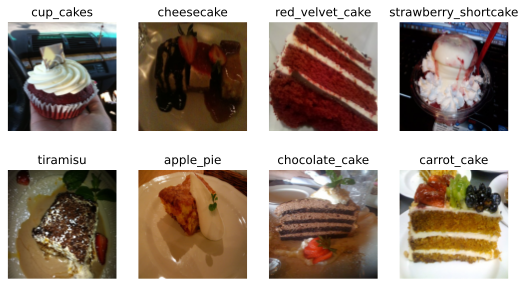

In [4]:
plt.figure(figsize=(9,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    ind = i*100
    plt.imshow(imgdata[ind])    
    plt.title(classes[ind])
    plt.axis('off')
plt.show()

Next, store the images into a Tensor. ResNet assumes the data is [0,255] range, so we need to scale the images that were read in with skimage.

In [5]:
Xraw = zeros((len(imgdata), 224, 224, 3))
for i,img in enumerate(imgdata):
    x = image.img_to_array(img)*255   # preprocessing expects range [0,255]
    x = expand_dims(x, axis=0)
    Xraw[i,:] = x

Finally, we convert the class label strings into class numbers.

In [6]:
# convert class strings into integers
print("class labels (strings):", unique(classes))
le = preprocessing.LabelEncoder()
Y = le.fit_transform(classes)
print("Converted labels:")
print(Y)
Yb = keras.utils.to_categorical(Y)
print(Yb.shape)

class labels (strings): ['apple_pie' 'carrot_cake' 'cheesecake' 'chocolate_cake' 'cup_cakes'
 'red_velvet_cake' 'strawberry_shortcake' 'tiramisu']
Converted labels:
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7
 7 7 7 7 7

## 2. Extract Deep features
Now preprocess the images in imdata and put them into a 4D tensor for ResNet.  Store it in a tensor `Xim`.  
Note that `preprocess_input` will overwrite its input data, so you may need to make a `copy` if you want to preserve `Xraw`.

In [7]:
### INSERT YOUR CODE HERE ###

In [8]:
# contains the model and support functions for ResNet50
import tensorflow.keras.applications.resnet50 as resnet 
from tensorflow.keras.preprocessing import image

Xraw1 = np.copy(Xraw)

Xim = zeros((len(imgdata), 224, 224, 3))

for i,img in enumerate(Xraw1):
    x = resnet.preprocess_input(img)
    Xim[i,:] = x
print(Xim.shape)
   

(800, 224, 224, 3)


Extract features from Resnet50, call it `Xf`.

In [9]:
### INSERT YOUR CODE HERE ###

In [10]:
# create an instance of the model w/o the last layer
model_f = resnet.ResNet50(weights='imagenet', 
                          include_top=False,  # remove the classification layer
                          pooling='avg')      # apply GlobalAveragePooling

# compute the features
Xf = model_f.predict(Xim)
print(Xf.shape)

(800, 2048)


## 3. Train a classifier
Split the data into training and testing for the classifier.

In [11]:


# randomly split data into train and test set
( trainXf, testXf,       # features 
  trainY, testY,         # class labels
  trainYb, testYb,       # class one-hot vectors
  trainXim, testXim,     # processed images
  trainXraw, testXraw,   # raw images
  trainimgdata, testimgdata,     # raw images
) = \
  model_selection.train_test_split(Xf, Y, Yb, Xim, Xraw, imgdata,
  train_size=0.8, test_size=0.2, random_state=4487)


print(trainXf.shape)
print(testXf.shape)
print(trainXim.shape)

(640, 2048)
(160, 2048)
(640, 224, 224, 3)


Now train a few traditional classifier (e.g, SVM, logistic regression, random forest, etc.) and compute the accuracy.

In [12]:
### INSERT YOUR CODE HERE ###

In [13]:
# setup the list of parameters to try
paramgrid = {'C': logspace(-3,3,20)}
print(paramgrid)

# setup cross-validation
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5,
                                     n_jobs=-1, verbose=True)

# run cross-validation (train for each split)
svmcv.fit(trainXf, trainY);

{'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [14]:
# predict
mypred = svmcv.predict(testXf)

acc = metrics.accuracy_score(testY, mypred)
print("test accuracy = " + str(acc))

#test accuracy = 0.6625
#test accuracy = 0.6875

test accuracy = 0.6625


# 4. Analyze results

Run the below code to visualize the predictions on the test set.  `mypred` are the class predictions from your classifier.

In [15]:
# get the class labels
predYcl = le.inverse_transform(mypred)
testYcl = le.inverse_transform(testY)

plt.figure(figsize=(10,50))
px = 8
py = int(ceil(len(predYcl)/5))
for i in range(len(predYcl)):
    plt.subplot(py,px,i+1)
    mytitle = predYcl[i] + "\n(" + testYcl[i] + ")" 
    plt.imshow(testimgdata[i], interpolation='nearest')
    plt.title(mytitle, size=8)
    plt.gca().set_axis_off() 

Now look at the confusion matrix

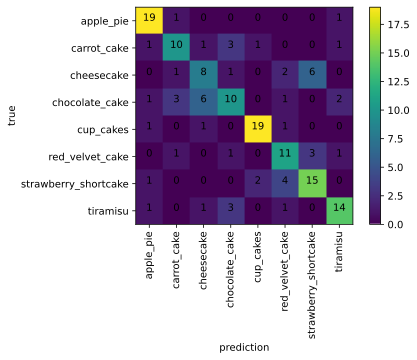

In [16]:
CM = metrics.confusion_matrix(testY, mypred)

plt.imshow(CM, interpolation='nearest')
plt.colorbar()

tick_marks = arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('prediction')
plt.ylabel('true')
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j,i,"{}".format(CM[i,j]), horizontalalignment='center')

_How does the classifier make errors?_
- **INSERT YOUR ANSWER HERE**
- ###########################
- The classifier is not as good as expected, errors high.

## 5. Transfer learning

Try using a pre-trained network as the backbone for a new network. You can try some of the following:
- training an MLP classifier using the 2048 features from ResNet.
- using other networks (e.g., InceptionNet) to extract the features.
  - remember to change the pre-processing step too.
- using the a feature map (7x7x2048) and applying a small CNN.
- fine-tuning the whole network.

In [17]:
### INSERT YOUR CODE HERE ####

In [18]:

#1. training an MLP classifier using the 2048 features from ResNet.

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# compatible with v1 or v2
def tf_compat():
    if tf.__version__[0] == '1':
        return (tf.set_random_seed, 'acc')
    else:
        return (tf.random.set_seed, 'accuracy')
    
tf_set_seed, accname = tf_compat()

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_'+accname,      # use validation accuracy for stopping
               min_delta=0.0001, patience=50, # tried 5, 10 , 50
               verbose=1, mode='auto')

LR_START = 0.00001
LR_MAX = 0.0001 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8
EPOCHS = 100

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', #'loss',
                              factor = 0.5,
                              patience = 4,
                              verbose = 1,
                              min_lr=0.000001,
                              min_delta = 0.0001)

callbacks_list = [earlystop, reduce_lr]

#opt = keras.optimizers.Adam(learning_rate=0.02)
opt = keras.optimizers.SGD(  # use SGD for optimization
               lr=0.005,       # learning rate (acc change fast, smooth)0.001, 0.01, 0.02, 0.05, 0.1, 1, 10(acc change slow) best: 0.02
               momentum=0.9,  # momentum for averaging over batches 
               nesterov=True  # use Nestorov momentum
        )


def build_model():
    mlp = Sequential()
    mlp.add(Flatten(input_shape=(2048,)))  #input dimension
    #mlp.add(Input(shape=(19,19,1)))
    mlp.add(Dense(units=1024,             # 2 nodes in the hidden layer 20; tried 32
                 activation='relu'))
    mlp.add(Dropout(0.5))
    mlp.add(Dense(units=128,             # 2 nodes in the hidden layer 20; tried 16
                 activation='relu'))
    mlp.add(Dropout(0.5))   #tried 0.5
    mlp.add(Dense(units=8,             # number of output nodes (classes)
                 activation='softmax' # softmax is for classification   #sigmoid
                )
          )
    mlp.summary()
    return mlp


In [19]:
mlp = build_model()

# compile the network
mlp.compile(
        loss=keras.losses.categorical_crossentropy,   # classification loss
        optimizer=opt,
        metrics=['accuracy']  # also calculate accuracy during training
        )


# fit the network
history = mlp.fit(trainXf, trainYb,                # the input/output data
                 epochs=200,           # number of iterations
                 batch_size=50,        # batch size (slow)16,32,50, 52,64(fast) best:50
                 callbacks=callbacks_list,
                 validation_split=0.3, # ratio of data for validation
                 #validation_data=validsetI,  # specify the validation set
                 verbose=True         # set to True to see each iteration
                )

#plot_history(history)

predY1 = argmax(mlp.predict(testXf, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY1)
print("test accuracy:", acc)

# 0.65
#test accuracy: 0.6625
#test accuracy: 0.66875

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 2,230,408
Trainable params: 2,230,408
Non-trainable params: 0
______________________________________________

Epoch 47/200
9/9 [==============================] - 0s 17ms/step - loss: 0.1672 - accuracy: 0.9519 - val_loss: 1.3274 - val_accuracy: 0.6354

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
Epoch 48/200
9/9 [==============================] - 0s 17ms/step - loss: 0.1816 - accuracy: 0.9423 - val_loss: 1.3274 - val_accuracy: 0.6354
Epoch 49/200
9/9 [==============================] - 0s 16ms/step - loss: 0.1684 - accuracy: 0.9519 - val_loss: 1.3273 - val_accuracy: 0.6354
Epoch 50/200
9/9 [==============================] - 0s 16ms/step - loss: 0.1672 - accuracy: 0.9608 - val_loss: 1.3273 - val_accuracy: 0.6354
Epoch 51/200
9/9 [==============================] - 0s 18ms/step - loss: 0.2061 - accuracy: 0.9276 - val_loss: 1.3271 - val_accuracy: 0.6354

Epoch 00051: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.
Epoch 52/200
9/9 [==============================] - 0s 20ms/step - loss: 0.1550 - accuracy: 0.9602 - val_loss: 1.3271 - val_accuracy

In [20]:
#2. using other networks (e.g., InceptionNet) to extract the features

from tensorflow.keras.applications import inception_resnet_v2 as incnet
from tensorflow.keras.preprocessing import image
#print( help('tensorflow.keras.applications'))

Xraw1 = np.copy(Xraw)

Xim = zeros((len(imgdata), 224, 224, 3))

for i,img in enumerate(Xraw1):
    x = incnet.preprocess_input(img)
    Xim[i,:] = x
print(Xim.shape)

# create an instance of the model w/o the last layer
model_f = incnet.InceptionResNetV2(weights='imagenet', 
                          include_top=False,  # remove the classification layer
                          pooling='avg')      # apply GlobalAveragePooling

# compute the features
Xf = model_f.predict(Xim)
print(Xf.shape)

# randomly split data into train and test set
( trainXf, testXf,       # features 
  trainY, testY,         # class labels
  trainYb, testYb,       # class one-hot vectors
  trainXim, testXim,     # processed images
  trainXraw, testXraw,   # raw images
  trainimgdata, testimgdata,     # raw images
) = \
  model_selection.train_test_split(Xf, Y, Yb, Xim, Xraw, imgdata,
  train_size=0.8, test_size=0.2, random_state=4487)


print(trainXf.shape)
print(testXf.shape)
print(trainXim.shape)

(800, 224, 224, 3)
(800, 1536)
(640, 1536)
(160, 1536)
(640, 224, 224, 3)


In [21]:
# setup the list of parameters to try
paramgrid = {'C': logspace(-3,3,25)}
print(paramgrid)

# setup cross-validation
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5,
                                     n_jobs=-1, verbose=True)

# run cross-validation (train for each split)
svmcv.fit(trainXf, trainY);

# predict
predY2 = svmcv.predict(testXf)

acc = metrics.accuracy_score(testY, predY2)
print("test accuracy = " + str(acc))
# test accuracy = 0.575

{'C': array([1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02, 1.77827941e+02, 3.16227766e+02, 5.62341325e+02,
       1.00000000e+03])}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
test accuracy = 0.575


In [23]:
#3. using the a feature map (7x7x2048) and applying a small CNN.

Xraw1 = np.copy(Xraw)

Xim = zeros((len(imgdata), 224, 224, 3))

for i,img in enumerate(Xraw1):
    x = resnet.preprocess_input(img)
    Xim[i,:] = x
print(Xim.shape)

# create an instance of the model w/o the last layer
base_model = resnet.ResNet50(weights='imagenet', 
                          include_top=False,  # remove the classification layer
                          #pooling='avg'  # apply GlobalAveragePooling
                          input_shape=(224, 224, 3)
                         )  

# compute the features
Xf = base_model.predict(Xim)
print(Xf.shape)

# randomly split data into train and test set
( trainXf, testXf,       # features 
  trainY, testY,         # class labels
  trainYb, testYb,       # class one-hot vectors
  trainXim, testXim,     # processed images
  trainXraw, testXraw,   # raw images
  trainimgdata, testimgdata,     # raw images
) = \
  model_selection.train_test_split(Xf, Y, Yb, Xim, Xraw, imgdata,
  train_size=0.8, test_size=0.2, random_state=4487)


print(trainXf.shape)
print(testXf.shape)
print(trainXim.shape)

(800, 224, 224, 3)
(800, 7, 7, 2048)
(640, 7, 7, 2048)
(160, 7, 7, 2048)
(640, 224, 224, 3)


In [24]:
def build_model1():
    mlp = Sequential()
    #mlp.add(Flatten(input_shape=(100352,)))  #input dimension
    mlp.add(Input(shape=(7,7,2048)))
    mlp.add(Flatten())
    
    mlp.add(Dense(units=1024,             # 2 nodes in the hidden layer 20; tried 32
                 activation='relu'))
    mlp.add(Dropout(0.5))
    mlp.add(Dense(units=128,             # 2 nodes in the hidden layer 20; tried 16
                 activation='relu'))
    mlp.add(Dropout(0.5))   #tried 0.5
    mlp.add(Dense(units=8,             # number of output nodes (classes)
                 activation='softmax' # softmax is for classification   #sigmoid
                )
          )
    mlp.summary()
    return mlp

mlp = build_model1()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1032      
Total params: 102,893,704
Trainable params: 102,893,704
Non-trainable params: 0
________________________________________

In [25]:
opt = keras.optimizers.SGD(  # use SGD for optimization
               lr=0.005,       # learning rate (acc change fast, smooth)0.001, 0.01, 0.02, 0.05, 0.1, 1, 10(acc change slow) best: 0.02
               momentum=0.9,  # momentum for averaging over batches 
               nesterov=True  # use Nestorov momentum
        )

callbacks_list = [earlystop, lr_callback]

# compile the network
mlp.compile(
        loss=keras.losses.categorical_crossentropy,   # classification loss
        optimizer=opt,
        metrics=['accuracy']  # also calculate accuracy during training
        )


# fit the network
history = mlp.fit(trainXf, trainYb,                # the input/output data
                 epochs=100,           # number of iterations
                 batch_size=50,        # batch size (slow)16,32,50, 52,64(fast) best:50
                 callbacks=callbacks_list,
                 validation_split=0.2, # ratio of data for validation
                 #validation_data=validsetI,  # specify the validation set
                 verbose=True         # set to True to see each iteration
                )

#plot_history(history)

predY3 = argmax(mlp.predict(testXf, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY3)
print("test accuracy:", acc)

#test accuracy: 0.6125
#test accuracy: 0.6

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
11/11 [==============================] - 5s 393ms/step - loss: 6.5225 - accuracy: 0.1092 - val_loss: 3.1751 - val_accuracy: 0.1094
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 1.6000000000000003e-05.
11/11 [==============================] - 4s 376ms/step - loss: 5.1151 - accuracy: 0.1798 - val_loss: 2.7765 - val_accuracy: 0.1328
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 2.2e-05.
11/11 [==============================] - 4s 385ms/step - loss: 4.3605 - accuracy: 0.1721 - val_loss: 2.4569 - val_accuracy: 0.1406
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 2.8000000000000003e-05.
11/11 [==============================] - 4s 378ms/step - loss: 3.2537 - accuracy: 0.2604 - val_loss: 2.1758 - val_accuracy: 0.2109
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 3.4e-05.
11/11 [==========================

## Analysis
For your best deep learning model, visualize the result and analyze the errors.

In [26]:
### INSERT YOUR CODE HERE ###

In [27]:
# get the class labels

mypred = predY1
predYcl = le.inverse_transform(mypred)
testYcl = le.inverse_transform(testY)

plt.figure(figsize=(10,50))
px = 8
py = int(ceil(len(predYcl)/5))
for i in range(len(predYcl)):
    plt.subplot(py,px,i+1)
    mytitle = predYcl[i] + "\n(" + testYcl[i] + ")" 
    plt.imshow(testimgdata[i], interpolation='nearest')
    plt.title(mytitle, size=8)
    plt.gca().set_axis_off() 

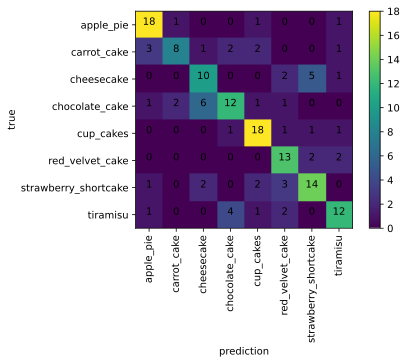

In [28]:
CM = metrics.confusion_matrix(testY, mypred)

plt.imshow(CM, interpolation='nearest')
plt.colorbar()

tick_marks = arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('prediction')
plt.ylabel('true')
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j,i,"{}".format(CM[i,j]), horizontalalignment='center')

_Where you able to improve the accuracy using deep learning? Analyze the errors from your best model._
- **INSERT YOUR ANSWER HERE**
- ###############################
- Data augmentation can improve the accuracy using deep learning.
- Apple pie and cup cakes are easy to recognize. carrot cake and cheese cake are hard to recognize.